In [1]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, transpile
from qiskit.tools.visualization import circuit_drawer, array_to_latex, plot_histogram
from qiskit.quantum_info import state_fidelity, partial_trace
from qiskit.quantum_info.operators import Operator, Pauli
from qiskit.quantum_info import process_fidelity, Statevector
from qiskit import Aer

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import math

In [3]:
# define scrambling unitary U
U = Operator([[-1,0,0,-1,0,-1,-1,0],
                 [0,1,-1,0,-1,0,0,1],
                 [0,-1,1,0,-1,0,0,1],
                 [1,0,0,1,0,-1,-1,0],
                 [0,-1,-1,0,1,0,0,1],
                 [1,0,0,-1,0,1,-1,0],
                 [1,0,0,-1,0,-1,1,0],
                 [0,-1,-1,0,-1,0,0,-1]]) * 0.5
array_to_latex(U)

# make U such that it depends on parameter alpha

<IPython.core.display.Latex object>

In [92]:
# define a function that builds the teleportation circuit,
# takes as input a (scrambling or not) unitary, a pair (a,b) to perform bell measurement on, an initial state,
# and maybe later on a parameter for the unitary phi/alpha,
# and outputs the counts
# and eventually the teleportation fidelity
def teleport(U,a,b,initial):
    
    i=0
    
    # U should be an operator
    # a,b should be either of the Bell pairs: (0,5) or (1,4) or (2,3)
    # initial should be any of the 6 Pauli eigenstates, in the format "i"
    # check if U is unitary
    var = U.is_unitary()
    if not var:
        return print('U is not unitary')
    # prepare the circuit
    q = QuantumRegister(7)
    c = ClassicalRegister(3)
    tc = QuantumCircuit(q,c)
    # set initial state (to ground state, except for q[0], which we set to any of the 6 Pauli eigenstates.)
    tc.initialize(initial,0)
    # preparing the initial bell states
    initq = QuantumRegister(2)
    init = QuantumCircuit(initq, name='EPR')
    init.h(initq[0])
    init.cx(initq[0],initq[1])
    init = init.to_instruction()
    tc.append(init, [1,4])
    tc.append(init, [2,3])
    tc.append(init, [5,6])
    tc.barrier()
    # add U
    tc.append(U,[0,1,2])
    tc.append(U,[5,4,3])
    tc.barrier()
    
    
    
    
    # add BELL projective measurement
    bellq = QuantumRegister(2)
    bellc = ClassicalRegister(2)
    bell = QuantumCircuit(bellq, bellc, name='Bell')
    bell.cx(0,1)
    bell.h(0)
    bell.measure(0,0)
    bell.measure(1,1)
    bell = bell.to_instruction()
    # add projective Bell measurement on either (0,5) or (1,4) or (2,3)
    tc.append(bell,[a,b],[1,2])
    
   
        
    backend = Aer.get_backend('qasm_simulator')
    job = backend.run(transpile(tc,backend), shots=1)
    result = job.result().get_counts()
    
    
    for key in result:
        cbit_value = key
    print(cbit_value)
    
    
   
    array = list(map(int, cbit_value))

    print(array)
    
   
    if array[1] == 0 and array[2] == 0:
        print('if')
        # add measurement of final qubit state
        tc.measure(6,0)
        return result
    else:
        print('else')
        return teleport(U,a,b,initial)
    
    
    

In [93]:
teleport(U,0,5,"0")

000
[0, 0, 0]
if


{'000': 1}

# How do I get it to also output a nice drawing?

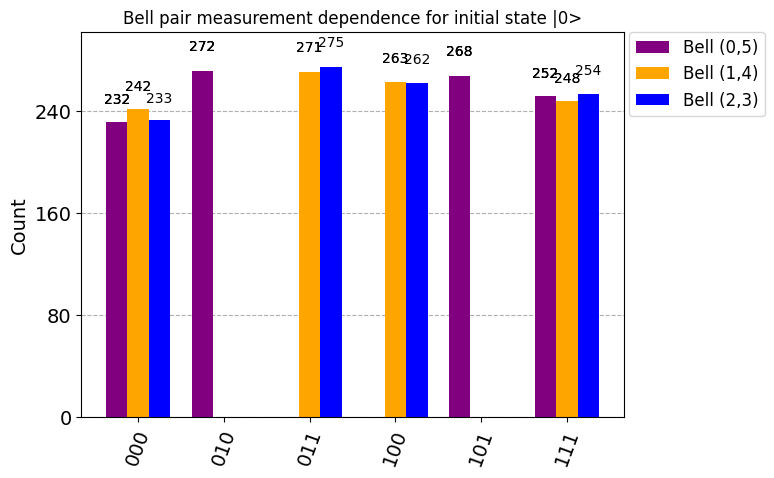

In [9]:
# plot histogram of circuit with varying Bell measurement pair and init=0
results = []
for i,j in [[0,5],[1,4],[2,3]]:
    results.append(teleport(U,i,j,"0"))
# results
legend = ['Bell (0,5)','Bell (1,4)','Bell (2,3)']
plot_histogram(results, legend=legend, color=['purple','orange','blue'],
               title='Bell pair measurement dependence for initial state |0>')

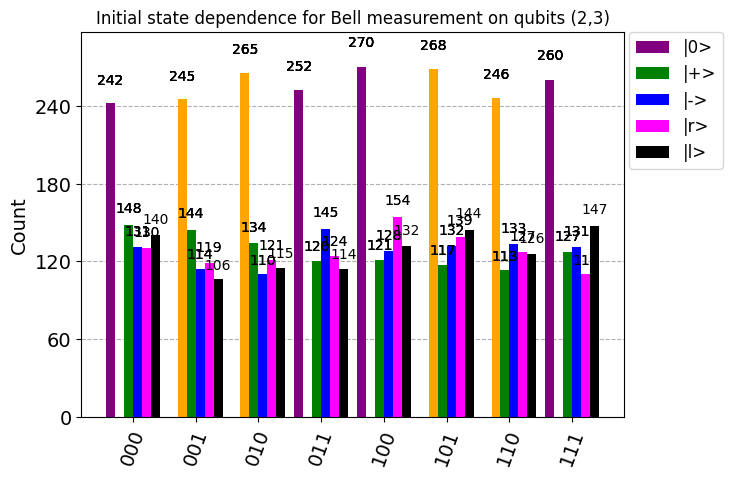

In [10]:
# plot histogram of circuit with varying initial state of first qubit and Bell measurement on (2,3)
results = []
for i in ["0","1","+","-","r","l"]:
    results.append(teleport(U,2,3,i))
# results
legend = ['|0>','|1>','|+>','|->','|r>','|l>']
plot_histogram(results,
                legend=legend, color=['purple','orange','green','blue','magenta','black'],
                title='Initial state dependence for Bell measurement on qubits (2,3)')

# where did the |-> go in the legend???? I suppose it has sth to do with the results with init=- not including any '000'

# Teleportation fidelity

In [76]:
# prepare quantum circuit
q = QuantumRegister(7)
c = ClassicalRegister(3)

tc = QuantumCircuit(q,c)

# initializing state of first qubit to |0>
#tc.initialize("0",0)

# preparing the initial bell states
initq = QuantumRegister(2)
init = QuantumCircuit(initq, name='EPR')
init.h(initq[0])
init.cx(initq[0],initq[1])
init = init.to_instruction()
tc.append(init, [1,4])
tc.append(init, [2,3])
tc.append(init, [5,6])
tc.barrier()
#qc.draw()

# add U
tc.append(U,[0,1,2])
tc.append(U,[5,4,3])
tc.barrier()

# save statevector before measurements
# ...

# could i use the state_fidelity() to find the teleportation fidelity?
#   partial trace to extract the final (single) qubit state of the last qubit:
state = Statevector.from_label('0000000').evolve(tc)
state_fidelity(Statevector.from_label('0'),partial_trace(state,[0,1,2,3,4,5,]))
# this is the teleportation fidelity, right?!



0.49999999999999994

In [77]:
# find teleportation fidelity for each of the 6 initial states
tfs = []
x=-1
list = ['0000000','1000000','+000000','-000000','r000000','l000000']
for i in ['0','1','+','-','r','l']:
    x += 1
    j = list[x]
    state = Statevector.from_label(j).evolve(tc)
    tfs.append(state_fidelity(Statevector.from_label(i),partial_trace(state,[0,1,2,3,4,5])))
tfs
# why aren't they all 1?
# of course, i need to select the right bell measurement first ....
# find out how to retrieve statevector before measurements, from qasm_similator, 
# and use this as input for state_fidelity (only if Bell was '00'!, so use classical condition)

[0.49999999999999994,
 0.49999999999999994,
 0.9999999999999996,
 0.9999999999999996,
 0.4999999999999998,
 0.4999999999999998]

In [78]:
# add measurement of final qubit state
tc.measure(6,0)

# add projective measurement
#   build a subsystem
bellq = QuantumRegister(2)
bellc = ClassicalRegister(2)
bell = QuantumCircuit(bellq, bellc, name='Bell')
bell.cx(0,1)
bell.h(0)
bell.measure(0,0)
bell.measure(1,1)
#   convert bell measurement to gate and insert in larger circuit
bell = bell.to_instruction()

# add projective Bell measurement on either (0,5) or (1,4) or (2,3)
tc.append(bell, [0,5],[1,2])

# draw circuit
tc.draw()

# send to backend and run with initial state |0>
backend = Aer.get_backend('qasm_simulator')
job = backend.run(transpile(tc,backend))
tcresults_0 = job.result().get_counts()

In [37]:
# U should be an operator
# a,b should be either of the Bell pairs: (0,5) or (1,4) or (2,3)
# initial should be any of the 6 Pauli eigenstates, in the format "i"
# check if U is unitary
var = U.is_unitary()
initial = "0"
a=2
b=3
# prepare the circuit
q = QuantumRegister(7)
c = ClassicalRegister(3)
tc = QuantumCircuit(q,c)
# set initial state (to ground state, except for q[0], which we set to any of the 6 Pauli eigenstates.)
tc.initialize(initial,0)
# preparing the initial bell states
initq = QuantumRegister(2)
init = QuantumCircuit(initq, name='EPR')
init.h(initq[0])
init.cx(initq[0],initq[1])
init = init.to_instruction()
tc.append(init, [1,4])
tc.append(init, [2,3])
tc.append(init, [5,6])
tc.barrier()
# add U
tc.append(U,[0,1,2])
tc.append(U,[5,4,3])
tc.barrier()




# add BELL projective measurement
bellq = QuantumRegister(2)
bellc = ClassicalRegister(2)
bell = QuantumCircuit(bellq, bellc, name='Bell')
bell.cx(0,1)
bell.h(0)
bell.measure(0,0)
bell.measure(1,1)
bell = bell.to_instruction()
# add projective Bell measurement on either (0,5) or (1,4) or (2,3)
tc.append(bell,[a,b],[1,2])
backend = Aer.get_backend('qasm_simulator')
job = backend.run(transpile(tc,backend))
result = job.result().get_counts()

for key in result:
    
    bitvalue = int(key)
    print(key[0])


1
1
0
0
